In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns
from IPython.display import Image

$$\newcommand{\isum}{\sum_{i}}$$
$$\newcommand{\zsum}{\sum_{k=1}^{K}}$$
$$\newcommand{\zsumi}{\sum_{\{z_i\}}}$$

## Mixture models

It is common to assume that observations are correlated due to some common “cause”. Hierarchical bayesian models are an example where we assume that information flows between observations through a tied-together set of higher level hyper-parameters. 

We can also construct models with 'hidden' or 'augmented' variables, also known as latent variable models, which may or may not correlate with a cause. Since such models often have fewer parameters than observations, they are useful in modelling many problems.

#### Mixture Definition
An example of a hidden model is the mixture model. A distribution $p(x \vert \theta_{k})$ is a mixture of $K$ component distributions $p_1, p_2,... p_K$ if:

$$p(x \vert \theta_{k}) = \sum_k \lambda_k p_{k}(x \vert \theta_k)$$

with the $\lambda_k$ being mixing weights, $\lambda_k > 0$, $\zsum \lambda_k = 1$.

That is, a mixture distribution is a weighted sum of other distributions, with the weights totalling to 1. Equivalently, values from a mixture distribution are found by first rolling a die with apropriate weights to see which component distribution is used, and then a value is drawn at random from that component.

The component distributions ($p_k$'s) can be completely arbitrary, but we usually assume they are from the same family, like Gaussians with different centers and variances, or Poissons with different means.

#### Drunk Monks as a mixture
We have already seen an example of a mixture mode with the zero-inflated poisson distribution, originally written as:

Likelihood of observing 0 is:

 $$\cal{L}(y=0) = p + (1-p) e^{-\,\theta},$$

and the Likelihood of a non-zero $y$ is:

 $$\cal{L}(y \ne 0) = (1-p) \frac{\theta^y e^{-\,\theta}}{y!}$$

This model can be described by this diagram, taken from Mc-Elreath

![](images/zinfmonks.png)

##### In mixture format
Fitting to the above definition, we'd have $p_1=Dirac(0)$, $p_2=Poisson(\theta)$, $\lambda_1=p$ and $\lambda_2=(1-p)$. A Dirac distribution at $a$ says "this has a 100% chance of returning $a$" 

This phrasing as a mixture model matches our story: the monks flip a coin to decide if it's a drinking day or not. If they drink, we observe 0. If they work we observe a draw from a posison.

(Sorry about overloading $p_1$ [the distribution ID] with $p$ [the probability that the monks drink and don't complete any books]. There are only so many letters in probability)


### Sampling from a Mixture
Suppose we have a mixture model: $p(x \vert \theta_{k}) = \sum_k \lambda_k p_{k}(x \vert \theta_k)$

The way to generate a new observation from a mixture distribution would be the following:

$$Z \sim Categorical(\lambda_1,\lambda_2,...,\lambda_K)$$

where $Z$ determines which component X is drawn from. Thus $\lambda_j$ is the probability that the hidden class variable $z$ is $j$. Then:

$$X \sim p_{z}(x \vert \theta_z)$$

This is just the same story over again: pick which distribution to sample from according to the weights, and then sample from the apropriate distribution. For a second sample, re-decide which distribution and get a point from that distribution.

## Special Case: Gaussian Mixture Models

The Gaussian mixture model or GMM is the most widely used mixture distribution. In this model, each base distribution  is a multivariate Gaussian with mean $\mu_k$ and covariance matrix $\Sigma_k$. Thus the model has the form

$$p(x \vert  \mu_k , \Sigma_k) = \zsum \lambda_k N(x \vert \mu_k , \Sigma_k ) $$

Thus each mixture component has a different set of eliptical contours, and we sum these to create our overall density.

In the code below, we sample from a mixture of three normal distributions and plot them.



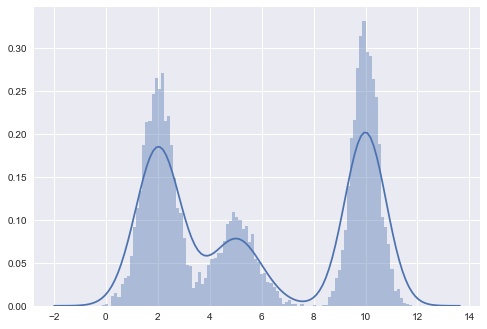

In [2]:
from scipy.stats import multinomial

#Mixture of three 1D normal distributions
# True parameter values
mu_true = np.array([2, 5, 10])
sigma_true = np.array([0.6, 0.8, 0.5])
lambda_true = np.array([.4, .2, .4])
n = 10000

#Decide which distribution we sample from on each trial
# returns n rows of 3 entries each. In each row exactly one entry is a 1,
# the rest are zero. The 1s occur based on the probabilites lambda_true
z = multinomial.rvs(1, lambda_true, size=n)

#done via a loop for clarity; production code should be vectorized
x=np.zeros(n)
for idx,row in enumerate(z):
    distribution_id = np.nonzero(row)[0]
    cur_mu = mu_true[distribution_id]
    cur_sigma = sigma_true[distribution_id]
    x[idx] = np.random.normal(cur_mu, cur_sigma)

#one-liner for the above
#x=np.array([np.random.normal(mu_true[i.astype('bool')][0], sigma_true[i.astype('bool')][0]) for i in z])

sns.distplot(x, bins=100);

### Application: Linear Discriminant Analysis is a Gaussian Mixture Model
LDA (a subset of Gaussian Discriminant Analysis) is a model where the data are assumed to come from K different normal distributions with mixing weights $\lambda_k$. In LDA each gaussian is assumed to have the same variance, in oder to make the math easier and faster. In GDA, each gaussian has its own varaince matrix and thus more data is needed from each class to estimate all the extra parameters.

LDA and GDA are both **supervised** algorithms/models: they require known class labels for each point in the training data.


#### Details
Suppose we have continuous-valued input data $x$, and labels $z$.  We call  $p(x,z \vert \theta)$ the **full-data likelihood**. Since we have both $z$ and $x$ on our training set, this is the likelihood we will want to maximize. Let us see how to obtain it.

Our model is (limiting ourselves to just two gaussians for simplicity):

$$ Z \sim \rm{Bernoulli}(\lambda) $$
$$ X\,\vert\,Z=0 \sim {\cal N}(\mu_0, \Sigma_0) $$
$$ X\,\vert\,Z=1 \sim {\cal N}(\mu_1, \Sigma_1) $$

Expanding, the distributions details are
$$ p(Z=z) = \lambda^z (1-\lambda)^{1-z}$$
$$ p(X=x \vert Z=0) = \frac{1}{(2\pi)^{n/2}  \vert  \Sigma \vert ^{1/2}} \exp \left( -\frac{1}{2}(x-\mu_0)^T \,\Sigma_0^{-1}(x-\mu_0) \right) $$
$$ p(X=x \vert Z=1) = \frac{1}{(2\pi)^{n/2}  \vert  \Sigma \vert ^{1/2}} \exp \left( -\frac{1}{2}(x-\mu_1)^T \,\Sigma_1^{-1}(x-\mu_1) \right) $$


where the parameters of the model $\lambda$, $\Sigma_0$, $\Sigma_1$, $\mu_0$ and $\mu_1$ are to be determined. 
From here on, for simplicity of exposition we will use one covariance matrix  $\Sigma$ for both Gaussians. Hence we'll be working with LDA instead of GDA.

**Likelihood**  
The full-data log-likelihood of the data is given 

$$
\begin{eqnarray}
 l(x,z \vert  \lambda,\mu_0, \mu_1, \Sigma) &=& \log \prod_{i=1}^{m} p(x_i,z_i \vert  \lambda, \mu_0, \mu_1, \Sigma) \nonumber \\ 
          &=& \sum_{i=1}^{m} \log \left[p(x_i \vert z_i,  \mu_0, \mu_1, \Sigma) \,p(z_i \vert  \lambda) \right]  \nonumber \\ 
          &=& \sum_{i=1}^{m} \log p(x_i \vert z_i,  \mu_0, \mu_1, \Sigma) + \sum_{i=1}^{m}  \log p(z_i \vert  \lambda)   \nonumber   \\      
	&=&  -\sum_{i=1}^{m} \log ((2\pi)^{n/2}  \vert  \Sigma \vert ^{1/2}) - \frac{1}{2} \sum_{i=1}^{m}  (x-\mu_{z_i})^T \,\Sigma^{-1}(x-\mu_{z_i})   \nonumber \\ 
		& & \quad \quad +\sum_{i=1}^{m} \left[ z_i \, \log \lambda + (1-z_i) \log(1-\lambda) \right]
\end{eqnarray}
$$

**Finding Estimators**  
Taking derivatives with respect to  $\lambda$, $\Sigma$, $\mu_0$ and $\mu_1$ and setting them to zero we get 

$$
\begin{eqnarray}
   \lambda & = &\frac{1}{m}  \sum_{i=1}^{m}  \delta_{z_i,1} \nonumber  \\ 
   \mu_0 &=& \frac{ \sum_{i=1}^{m}  \delta_{z_i,0} \, x_i  }{ \sum_{i=1}^{m}   \delta_{z_i,0}}\nonumber  \\ 
    \mu_1 &=& \frac{ \sum_{i=1}^{m}  \delta_{z_i,1} \, x_i  }{ \sum_{i=1}^{m}   \delta_{z_i,1}}\nonumber  \\ 
 \Sigma &=&\frac{1}{m}   \sum_{i=1}^{m}  (x_i-\mu_{z_i})   (x_i-\mu_{z_i})^{T} 
\end{eqnarray}
$$

This gives us the obvious result, namely $\lambda$ is nothing more but the fraction of objects with label $z=1$ and the total 
number of objects, $\mu$'s are the mean within the class and $\Sigma$ is the the covariance matrix 
for each group. This analysis is called "Gaussian Discriminant Analysis" or GDA, here specifically LDA as we tied the covariance matrices.


#### Fitting LDA
Lets do this in code.

**Build a (simulated) dataset**

In [3]:
#In 1-D
# True parameter values
mu_true = np.array([2, 5])
sigma_true = np.array([0.6, 0.6])
lambda_true = np.array([.4, .6])
n = 10000

# Simulate from each distribution according to mixing proportion lambda_true
from scipy.stats import binom
z = binom.rvs(1, lambda_true[0], size=n)
x=np.array([np.random.normal(mu_true[i], sigma_true[i]) for i in z])

Now we split into a training set and a test set.

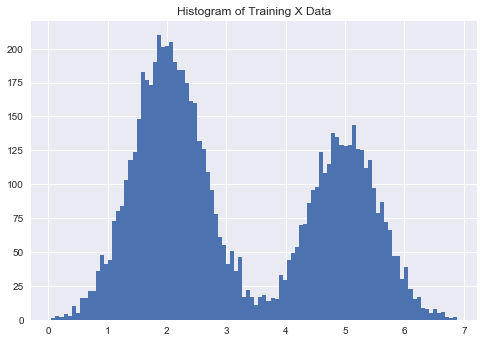

In [4]:
#the z's are the classes in the supervised learning
#the 'feature' is the x position of the sample
from sklearn.model_selection import train_test_split
ztrain, ztest, xtrain, xtest = train_test_split(z,x)

plt.hist(xtrain,100)
plt.title("Histogram of Training X Data");

**Fit the LDA model** to the training data using the estimators found above.

In [5]:
lambda_train=np.mean(ztrain)
mu0_train = np.sum(xtrain[ztrain==0])/(np.sum(ztrain==0))
mu1_train = np.sum(xtrain[ztrain==1])/(np.sum(ztrain==1))
xmus = np.array([mu0_train if z==0 else mu1_train for z in ztrain])
xdiffs = xtrain - xmus
sigma_train = np.sqrt(np.dot(xdiffs, xdiffs)/xtrain.shape[0])
print(lambda_train, mu0_train, mu1_train, sigma_train)

0.401866666667 2.00605950106 4.9905681261 0.600912607754


**Using the model**  
Great, we've got a fitted model. How should we do classification?

We can use the log likelihood at a given `x` as a classifier: assign the class '0' or '1' depending upon which class is more likely to produce x values in at that point (i.e. which probability $p(x_j \vert \lambda, z, \Sigma)$ is larger). Note that this is JUST the $x$ likelihood; z is given because we want to compare probabilities for fixed $z$s.

$$log\,p(x_j \vert \lambda, z, \Sigma) = -\sum_{i=1}^{m} \log ((2\pi)^{n/2}  \vert  \Sigma \vert ^{1/2}) - \frac{1}{2} \sum_{i=1}^{m}  (x-\mu_{z_i})^T \,\Sigma^{-1}(x-\mu_{z_i})  $$

The first term of the likelihood does not matter since it is independent of $z$, therefore:

In [7]:
def loglikdiff(x):
    for0= - (x-mu0_train)*(x-mu0_train)/(2.0*sigma_train*sigma_train) 
    for0 = for0 + np.log(1.-lambda_train)
    for1 = - (x-mu1_train)*(x-mu1_train)/(2.0*sigma_train*sigma_train) 
    for1 = for1 + np.log(lambda_train)
    return 1*(for1 - for0 >= 0)

pred = np.array([loglikdiff(test_x) for test_x in xtest])
print("Correct classification rate", np.mean(ztest == pred))

Correct classification rate 0.9944


**Conclusion**: The model did well, and could reliably decide which normal distribution a given data point came from. This strong performance is partly becuase the model assumptions were true (the two distributions really were Gaussian) and partly because the two gaussians were spatially well-separated. If they had overlapped more there would have been more confusion.

This problem was also easy becuase we knew ahead of time which class / which gaussian each point belonged to. It would have been meaningfully more difficult to find the correct shape of each gaussian if we had to guess which gaussian particular points came from.